In [1]:
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, regularizers, callbacks
from sklearn.decomposition import PCA
from data_wrangling.datamanager import DataLoader

In [2]:
dl = DataLoader()
data = dl.get_fcx2(['s1'])

In [3]:
X1 = data['s1']['data']
mn = X1.mean(0).reshape((1, -1))
st = X1.std (0).reshape((1, -1))
X1 = (X1 - mn) / st
X1.shape

(1303952, 73)

In [4]:
fs = 1000

idxs_train_test_split = int(len(X1) * 0.7)

t_in  = 1e-1
t_out = 1e-2

p_in  = int(fs * t_in)
p_out = int(fs * t_out)

step  = int(fs * 1e-2) 

idxs_train = np.arange(0, idxs_train_test_split - p_out - p_in, step)

X_train = np.stack([
    X1[idx : idx + p_in]
    for idx in idxs_train
])

Y_train = np.stack([
    X1[idx + p_in : idx + p_in + p_out]
    for idx in idxs_train
])

X_train.shape, Y_train.shape

((91266, 100, 73), (91266, 10, 73))

In [5]:
def make_model_architecture_1(
    X, Y,
    
    dense_pre_n_layers,
    dense_pre_n_units,
    
    bidirectional_encoder_n_layers,
    bidirectional_encoder_n_units,
    
    dense_mid_n_layers,
    dense_mid_n_units,
    
    lstm_decoder_n_units,
    
    bidirectional_decoder_n_layers,
    bidirectional_decoder_n_units,
    
    dense_post_n_layers,
    dense_post_n_units
):
    '''
        Architecture:
        
        X (input) shape (n timesteps in, n channels)
        
        dense_pre_n_layers number of:
            Dense(dense_pre_n_units)
            BatchNormalization
            ReLU
            
        (bidirectional_encoder_n_layers - 1) number of:
            Bidirectional(
                LSTM(
                    bidirectional_encoder_n_units,
                    return_sequences = True
                )
            )
            
        Bidirectional(
            LSTM(
                bidirectional_encoder_n_units,
                return_sequences = False
            )
        )
            
        dense_mid_n_layers number of:
            Dense(dense_mid_n_units)
            BatchNormalization
            ReLU
            
        RepeatVector(n timesteps out)
        LSTM(
            lstm_decoder_n_units,
            return_sequences = True
        )
        
        bidirectional_decoder_n_layers number of:
            Bidirectional(
                LSTM(
                    bidirectional_decoder_n_units,
                    return_sequences = True
                )
            )
        
        dense_post_n_layers number of:
            Dense(dense_post_n_units)
            BatchNormalization
            ReLU
            
        Dense(n channels) shape (n timesteps out, n channels)
        
    '''
    
    def dense_unit(units):
        return [
            layers.Dense(units),
            layers.BatchNormalization(),
            layers.ReLU()
        ]
    
    def bidirectional_unit(units, return_sequences):
        return layers.Bidirectional(
            layers.LSTM(
                units,
                return_sequences = return_sequences
            )
        )
    
    model = keras.Sequential()
    model.add(layers.Input(X.shape[1:]))
    
    for i in range(dense_pre_n_layers):
        for l in dense_unit(dense_pre_n_units):
            model.add(l)
            
    for i in range(bidirectional_encoder_n_layers - 1):
        model.add(bidirectional_unit(bidirectional_encoder_n_units, True))
    model.add(bidirectional_unit(bidirectional_encoder_n_units, False))
    
    for i in range(dense_mid_n_layers):
        for l in dense_unit(dense_mid_n_units):
            model.add(l)
    
    model.add(layers.RepeatVector(Y.shape[1]))
    model.add(layers.LSTM(
        lstm_decoder_n_units,
        return_sequences = True
    ))
    
    for i in range(bidirectional_decoder_n_layers):
        model.add(bidirectional_unit(bidirectional_decoder_n_units, True))
    
    for i in range(dense_post_n_layers):
        for l in dense_unit(dense_post_n_units):
            model.add(l)
            
    model.add(layers.Dense(Y.shape[-1]))
    model.compile(loss = 'mse', optimizer = 'adam')
    return model

In [6]:
model = make_model_architecture_1(
    X_train, Y_train,
    0, 0,
    1, 128,
    0, 0,
    128,
    1, 64,
    0, 0
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               206848    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           197120    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 128)           98816     
_________________________________________________________________
dense (Dense)                (None, 10, 73)            9417      
Total params: 512,201
Trainable params: 512,201
Non-trainable params: 0
_________________________________________________________________


In [7]:
hist = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    batch_size = 512,
    validation_split = 0.2
)

Epoch 1/20
143/143 [==============================] - 12s 55ms/step - loss: 0.5082 - val_loss: 0.1601
Epoch 2/20
143/143 [==============================] - 7s 47ms/step - loss: 0.1228 - val_loss: 0.1076
Epoch 3/20
143/143 [==============================] - 7s 47ms/step - loss: 0.0867 - val_loss: 0.0877
Epoch 4/20
143/143 [==============================] - 7s 48ms/step - loss: 0.0720 - val_loss: 0.0802
Epoch 5/20
143/143 [==============================] - 7s 47ms/step - loss: 0.0645 - val_loss: 0.0733
Epoch 6/20
143/143 [==============================] - 7s 48ms/step - loss: 0.0599 - val_loss: 0.0693
Epoch 7/20
143/143 [==============================] - 7s 48ms/step - loss: 0.0559 - val_loss: 0.0669
Epoch 8/20
143/143 [==============================] - 7s 48ms/step - loss: 0.0539 - val_loss: 0.0694
Epoch 9/20
143/143 [==============================] - 7s 48ms/step - loss: 0.0538 - val_loss: 0.0688
Epoch 10/20
143/143 [==============================] - 7s 48ms/step - loss: 0.0854 - val_l

In [8]:
hist = model.fit(
    X_train,
    Y_train,
    epochs = 20,
    batch_size = 128,
    validation_split = 0.3
)

Epoch 1/20
500/500 [==============================] - 12s 24ms/step - loss: 0.0559 - val_loss: 0.0647
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0527 - val_loss: 0.0613
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0499 - val_loss: 0.0602
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0475 - val_loss: 0.0594
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0533 - val_loss: 0.0591
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0470 - val_loss: 0.0559
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0459 - val_loss: 0.0590
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0445 - val_loss: 0.0549
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.0598 - val_loss: 0.0666
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.049

In [9]:
pred = []
real = []
for idx in range(idxs_train_test_split, len(X1) - p_out - p_in, p_out):
    x = X1[idx : idx + p_in].reshape((1, p_in, -1))
    y = X1[idx + p_in : idx + p_in + p_out]
    pred.append(x)
    real.append(y)
    
per_stride = 512
strides = int(len(pred) / per_stride) + 1
pred = np.concatenate([
    model(
        np.concatenate(pred[stride * per_stride : (stride + 1) * per_stride])
    ).numpy()
    for stride in range(strides)
])

real = np.stack(real)

pred.shape, real.shape

((39108, 10, 73), (39108, 10, 73))

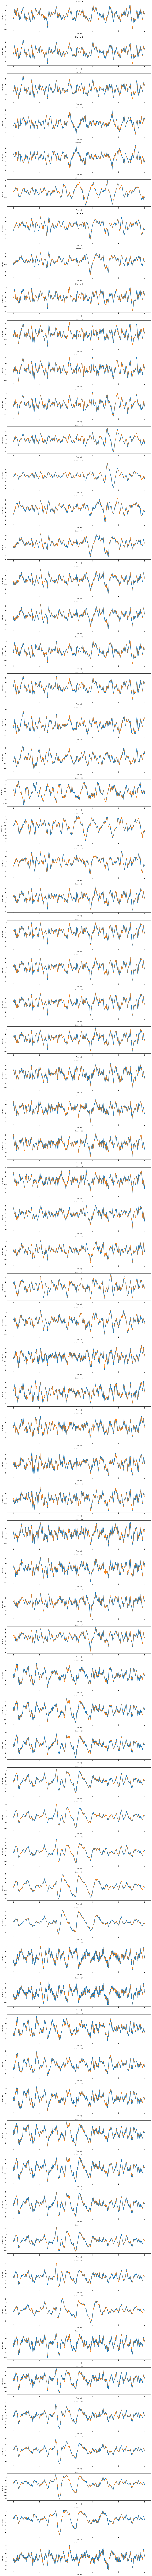

In [10]:
n_channels = real.shape[-1]
plt.figure(figsize = (20, 5 * n_channels))
n_steps = 500
plt.subplots_adjust(hspace = 0.3)

for chan in range(real.shape[-1]):

    plt.subplot(n_channels, 1, chan + 1)
    plt.title(f'Channel {chan + 1}')
    plt.plot(
        np.linspace(0, p_out * n_steps / fs, n_steps * p_out), 
        real[:n_steps, :, chan].flatten(), 
        linewidth = 3
    )
    plt.plot(
        np.linspace(0, p_out * n_steps / fs, n_steps * p_out), 
        pred[:n_steps, :, chan].flatten(), 
        linewidth = 1
    )
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [V]')
    
plt.show()